In [1]:
import pandas as pd
import numpy as np
from decimal import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
pwd

'/Users/aashnashah/Dropbox/Research/PFT-ML/sitting_height'

In [3]:
ukb = pd.read_csv('../processed/ukb_2023-03-14.csv', index_col=0)

                     # Baseline 
ukb_clean = ukb[['RIDRETH', 'RIDAGEYR', "RIAGENDR",
                     # Anthropometric
                     'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
                     'BMXSIT'
                ]].dropna()

ukb_clean = ukb_clean.reset_index(drop=True)

In [4]:
def bootstrap(X_train, y_train, n_bootstraps):

    # Initialize array to store bootstrap coefficients
    models = []

    # Perform bootstrap resampling and Lasso regression on training data
    for i in range(n_bootstraps):
        # Generate bootstrap sample
        indices = np.random.choice(X_train.index, size=X_train.shape[0], replace=True)
        X_boot = X_train.loc[indices]
        y_boot = y_train[indices]
        model = Ridge(alpha=0.01)
        model.fit(X_boot, y_boot)
        models.append(model)
        
    return models

def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

def one_hot_encode(X, columns = ['RIDRETH']):
    categorical_columns = columns
    for column in categorical_columns:
        one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.drop(column, axis=1)
        X = X.join(one_hot)
    return X

def scale(X, columns, feature = 'With Race'):
    X_num = X[numerical_columns]
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_num))
    X_scaled.columns = X_num.columns
    return X_scaled

def plot(y_test, y_pred, i, race, dataset, feature):
    palette = sns.color_palette("husl", 6)
    r2_race = r2_score(y_test, y_pred)

    # Calculate regression line
    reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test)
    line_x = np.arange(65, 110).reshape(-1, 1)
    line_y = reg.predict(line_x)
    
    # Calculate perfect regression line
    reg = LinearRegression().fit(y_test.values.reshape(-1,1) , y_test)
    perf_line_x = np.arange(65, 110).reshape(-1, 1)
    perf_line_y = reg.predict(line_x)
    
    # Create scatterplot and plot line of best fit
    axs[i].scatter(y_pred, y_test, alpha = 0.5, s = 10, color = palette[i])
    axs[i].plot(line_x, line_y, linestyle='--', linewidth=2, color = palette[i])
    axs[i].plot(perf_line_x, perf_line_x, linestyle='--', label='R2: 1', linewidth=2, alpha=0.7, color = 'darkblue')

    axs[i].set_title(f'{dataset}: {race} \n R2:{round(r2_race,2)} ( +/- {Decimal(ci_r2s):.2E} )')
    axs[i].set_xlim(65, 110)
    axs[i].set_ylim(65, 110)
    
    # Add title, axis labels, and legend to plot
    axs[i].set_xlabel(f'Predicted {feature}', fontsize = 10)
    axs[i].set_ylabel('Observed', fontsize = 10)
    return plt

# Predicting Sitting Height (Race Included)

## Train and Test on UKB

In [5]:
X = ukb_clean.drop(['BMXSIT'], axis = 1)
y = ukb_clean['BMXSIT']
 
X = one_hot_encode(X)

X['RIDRETH_Hispanic'] = 0
categorical_columns = list(ukb_clean.select_dtypes(include=['object']).columns)
numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']

X['RIAGENDR'] = X['RIAGENDR'].astype(int)

X_scaled = scale(X, numerical_columns)
X_encoded = X.drop(numerical_columns, axis=1)
X_new = pd.concat([X_scaled, X_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    stratify=X_new.join(ukb_clean['RIDRETH'])['RIDRETH'],
                                                    test_size=0.2, random_state=42)
    

In [6]:
X_train.head()

,RIDAGEYR,BMXHT,BMXWT,BMXBMI,BMXWAIST,RIAGENDR,RIDRETH_Asian,RIDRETH_Black,RIDRETH_Other,RIDRETH_South Asian,RIDRETH_White,RIDRETH_Hispanic
471936,1.228638,0.166950,0.391909,0.362325,0.350285,0,0,0,0,0,1,0
176654,0.117475,-0.372137,-0.135149,0.093361,0.870017,0,0,0,0,0,1,0
272566,-0.252912,1.784211,1.013085,0.019369,0.498780,0,0,0,0,0,1,0
224095,-1.857925,1.029489,1.565242,1.058051,0.350285,1,0,0,0,0,1,0
413956,-0.129450,-0.587771,-1.044953,-0.900397,-1.431653,1,0,0,0,0,1,0


In [7]:
models = bootstrap(X_train, y_train, n_bootstraps=50)
maes, mses, r2s = [], [], []
for m in models:  
    y_pred = m.predict(X_test)
    # Calculate the MAE and CI for all people
    mae, mse, r2 = evaluate(y_test, y_pred)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

model = Ridge()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Train the model with the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
mean_score = -grid_search.best_score_

y_pred = model.predict(X_test)
mae, mse, r2 = evaluate(y_test, y_pred)
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)


MAE: 1.7399401358558835
MSE: 5.820230307499684
R2: 0.7553716114074487


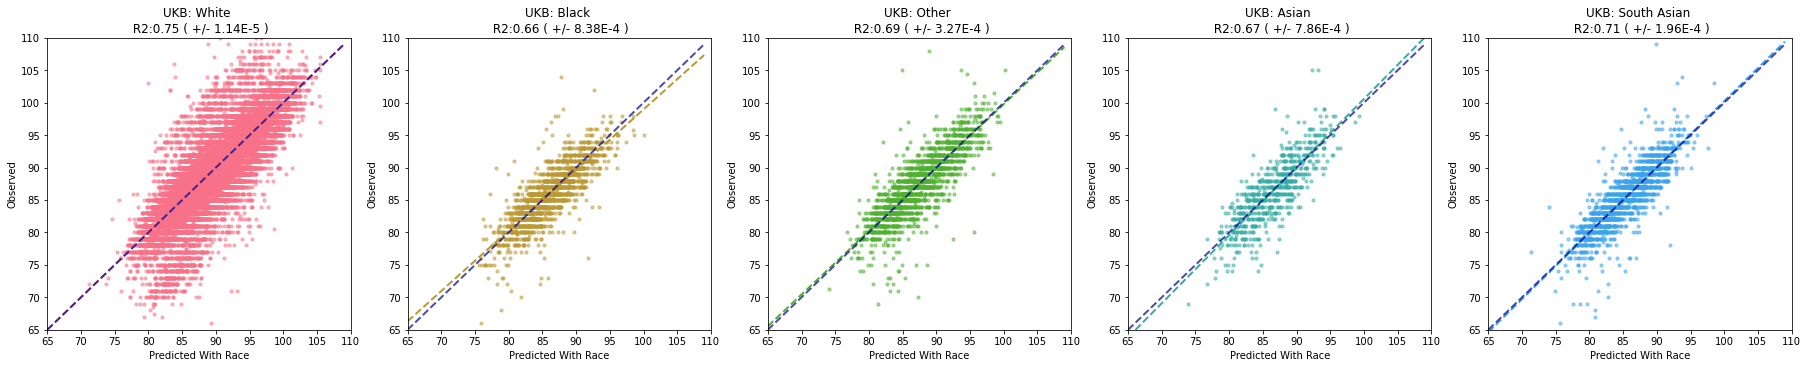

In [8]:
race_columns = ['RIDRETH_White', 'RIDRETH_Black', 'RIDRETH_Other', 'RIDRETH_Asian', 'RIDRETH_South Asian']
fig1, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)

for i, r in enumerate(race_columns):
    r2s = []
    for m in models:  
        y_test_race = y_test[X_test[X_test[r]==1].index]
        y_pred_race = m.predict(X_test[X_test[r]==1])
        mae, mse, r2 = evaluate(y_test_race, y_pred_race)
        r2s.append(r2)
    
    z_score = 1.96  # 95% confidence interval
    ci_r2s = z_score*np.std(r2s, ddof=1)
    
    y_test_race = y_test[X_test[X_test[r]==1].index]
    y_pred_race = model.predict(X_test[X_test[r]==1])
    
    race = r.split('_')[1]
    plot(y_test_race, y_pred_race,  i, race, dataset = 'UKB', feature = 'With Race')

## Test on all of NHANES III (Race-Included)


In [9]:
nhanes3 = pd.read_csv('../data/nhanes3_adult_2023-04-02.csv')

# rename the columns
nhanes3_clean = nhanes3.rename(columns={
    'BMXSITHT': 'BMXSIT',
    'IS_FEMALE': 'RIAGENDR', })[['RIAGENDR', 'RIDAGEYR', 
     'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
     'BMXSIT' , 'RIDRETH']].dropna()

nhanes3_clean = nhanes3_clean.reset_index(drop = True)
nhanes3_clean['RIAGENDR'] = nhanes3_clean['RIAGENDR'].astype(int)
nhanes3_clean = nhanes3_clean[nhanes3_clean['RIDRETH'].isin(['White', 'Hispanic', 'Black', 'Other'])]

In [10]:
X = nhanes3_clean.drop(['BMXSIT'], axis = 1)
X['RIDRETH_Asian'] = 0
X['RIDRETH_South Asian'] = 0 
y = nhanes3_clean['BMXSIT']
    
X = one_hot_encode(X)

numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']
X_scaled = scale(X, numerical_columns)
X_encoded = X.drop(numerical_columns, axis=1)
X = pd.concat([X_scaled, X_encoded], axis=1)[X_train.columns]

In [11]:
X.head()

,RIDAGEYR,BMXHT,BMXWT,BMXBMI,BMXWAIST,RIAGENDR,RIDRETH_Asian,RIDRETH_Black,RIDRETH_Other,RIDRETH_South Asian,RIDRETH_White,RIDRETH_Hispanic
0,-1.241410,1.250872,0.383836,-0.244904,-0.251606,0,0,0,0,0,0,1
1,-0.687956,-0.444404,-0.741804,-0.608599,-0.136043,1,0,0,0,0,0,1
2,0.117068,-0.985667,-0.380697,0.118791,-0.204021,1,0,0,0,0,1,0
3,-0.537014,1.107897,0.998847,0.430529,0.659304,0,0,0,0,0,1,0
4,0.117068,0.168346,-0.236818,-0.331498,0.101881,0,0,0,0,0,0,1


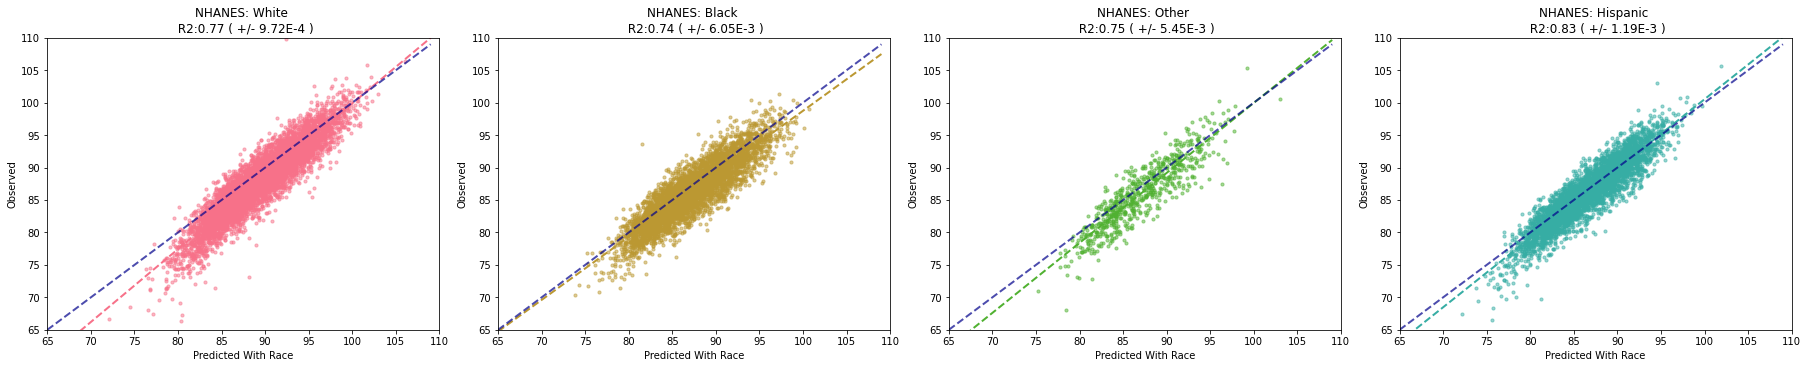

In [12]:
fig2, axs = plt.subplots(1, 4, figsize=(25, 5), constrained_layout=True)

race_columns = [ 'RIDRETH_White', 'RIDRETH_Black', 'RIDRETH_Other','RIDRETH_Hispanic']
for i, r in enumerate(race_columns):
    r2s = []
    for m in models:  
        y_test_race = y[X[X[r]==1].index]
        y_pred_race = m.predict(X[X[r]==1])
        mae, mse, r2 = evaluate(y_test_race, y_pred_race)
        r2s.append(r2)
    
    z_score = 1.96  # 95% confidence interval
    ci_mae = z_score*np.std(maes, ddof=1)
    ci_mse = z_score*np.std(mse, ddof=1)
    ci_r2s = z_score*np.std(r2s, ddof=1)
    
    y_test_race = y[X[X[r]==1].index]
    y_pred_race = model.predict(X[X[r]==1])

    race = r.split('_')[1]
    plot(y_test_race, y_pred_race, i, race, dataset = 'NHANES', feature = 'With Race')


# Predicting Sitting Height (Without Race)

## Train and Test on UKB

In [13]:
X = ukb_clean.drop(['BMXSIT', 'RIDRETH'], axis = 1)
y = ukb_clean['BMXSIT']

numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']

X['RIAGENDR'] = X['RIAGENDR'].astype(int)

X_scaled = scale(X, numerical_columns)
X_encoded = X.drop(numerical_columns, axis=1)
X_new = pd.concat([X_scaled, X_encoded], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    stratify=X_new.join(ukb_clean['RIDRETH'])['RIDRETH'],
                                                    test_size=0.2, random_state=42)

In [14]:
X_train.head()

,RIDAGEYR,BMXHT,BMXWT,BMXBMI,BMXWAIST,RIAGENDR
471936,1.228638,0.166950,0.391909,0.362325,0.350285,0
176654,0.117475,-0.372137,-0.135149,0.093361,0.870017,0
272566,-0.252912,1.784211,1.013085,0.019369,0.498780,0
224095,-1.857925,1.029489,1.565242,1.058051,0.350285,1
413956,-0.129450,-0.587771,-1.044953,-0.900397,-1.431653,1


In [15]:
models = bootstrap(X_train, y_train, n_bootstraps=50)
maes, mses, r2s = [], [], []
for m in models:  
    y_pred = m.predict(X_test)
    # Calculate the MAE and CI for all people
    mae, mse, r2 = evaluate(y_test, y_pred)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Train the model with the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
mean_score = -grid_search.best_score_

y_pred = model.predict(X_test)
mae, mse, r2 = evaluate(y_test, y_pred)
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

MAE: 1.776207465752928
MSE: 6.040847123265924
R2: 0.7460989308972337


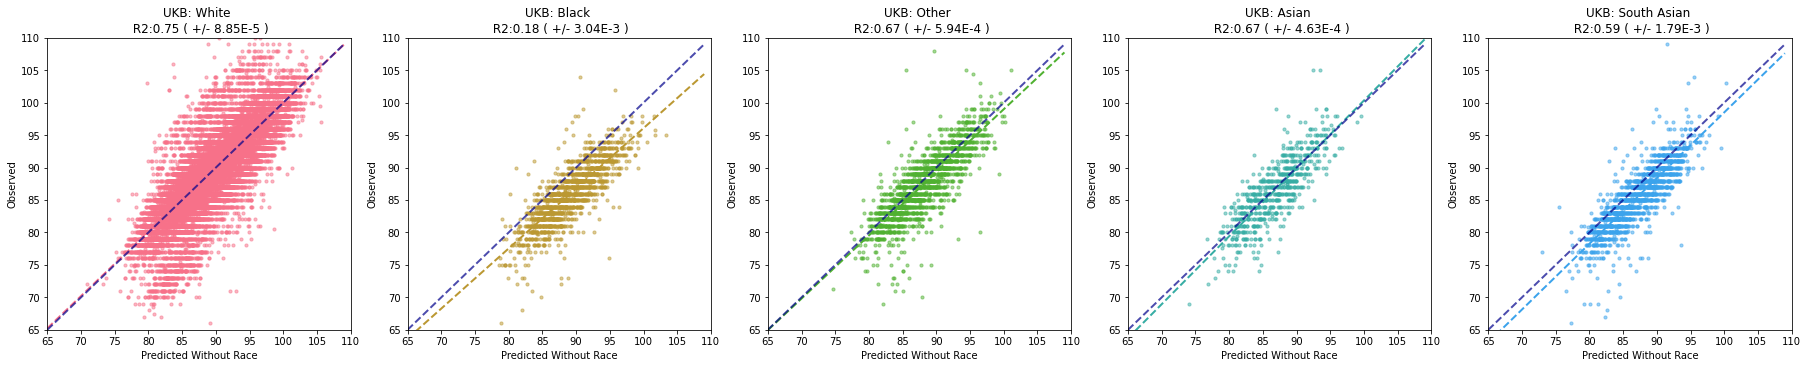

In [16]:
race_columns = ['White', 'Black', 'Other', 'Asian', 'South Asian']
fig3, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)

X_test_race_all = X_test.join(ukb_clean['RIDRETH'])
for i, r in enumerate(race_columns):
    X_test_race = X_test_race_all[X_test_race_all['RIDRETH'] == r].drop('RIDRETH', axis=1)
    y_test_race = y_test[X_test_race.index]
    
    r2s = []
    for m in models:  
        y_pred_race = m.predict(X_test_race)
        mae, mse, r2 = evaluate(y_test_race, y_pred_race)
        r2s.append(r2)
    
    z_score = 1.96  # 95% confidence interval
    ci_r2s = z_score*np.std(r2s, ddof=1)
    
    y_pred_race = model.predict(X_test_race)
    plot(y_test_race, y_pred_race,  i, r, dataset = 'UKB', feature = 'Without Race')

## Test on all of NHANES III (Without Race)

In [17]:
X = nhanes3_clean.drop(['BMXSIT'], axis = 1)
X['RIDRETH_Asian'] = 0
X['RIDRETH_South Asian'] = 0 
y = nhanes3_clean['BMXSIT']
    
X = one_hot_encode(X)

numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']
X_scaled = scale(X, numerical_columns)
X_encoded = X.drop(numerical_columns, axis=1)
X = pd.concat([X_scaled, X_encoded], axis=1)[X_train.columns]

In [18]:
X.head()

,RIDAGEYR,BMXHT,BMXWT,BMXBMI,BMXWAIST,RIAGENDR
0,-1.241410,1.250872,0.383836,-0.244904,-0.251606,0
1,-0.687956,-0.444404,-0.741804,-0.608599,-0.136043,1
2,0.117068,-0.985667,-0.380697,0.118791,-0.204021,1
3,-0.537014,1.107897,0.998847,0.430529,0.659304,0
4,0.117068,0.168346,-0.236818,-0.331498,0.101881,0


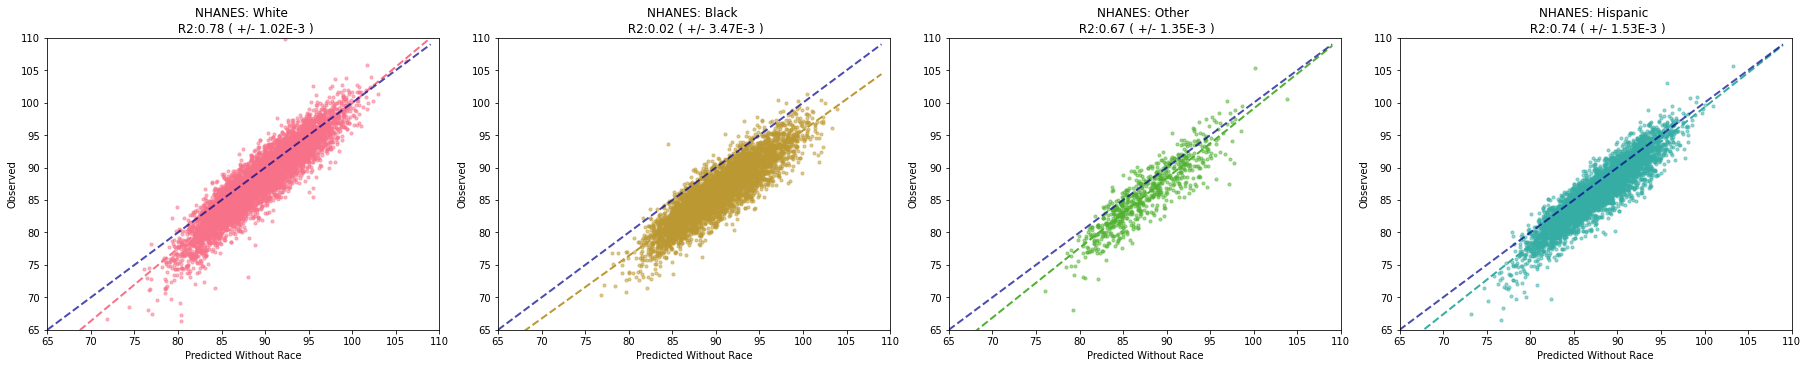

In [19]:
race_columns = ['White', 'Black', 'Other', 'Hispanic']
fig4, axs = plt.subplots(1, 4, figsize=(25, 5), constrained_layout=True)

X_test_race_all = X.join(nhanes3_clean['RIDRETH'])
for i, r in enumerate(race_columns):
    X_test_race = X_test_race_all[X_test_race_all['RIDRETH'] == r].drop('RIDRETH', axis=1)
    y_test_race = y[X_test_race.index]
    
    r2s = []
    for m in models:  
        y_pred_race = m.predict(X_test_race)
        mae, mse, r2 = evaluate(y_test_race, y_pred_race)
        r2s.append(r2)
    
    z_score = 1.96  # 95% confidence interval
    ci_r2s = z_score*np.std(r2s, ddof=1)
    
    y_pred_race = model.predict(X_test_race)
    plot(y_test_race, y_pred_race,  i, r, dataset = 'NHANES', feature = 'Without Race')

# All Plots: 

WITH RACE AS COVARIATE:


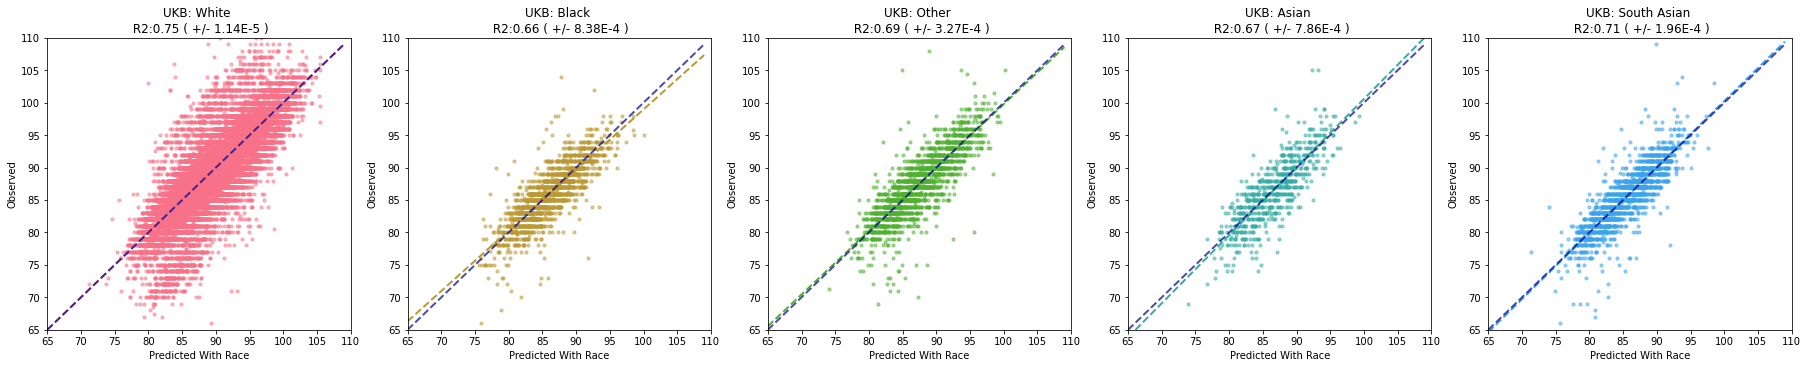

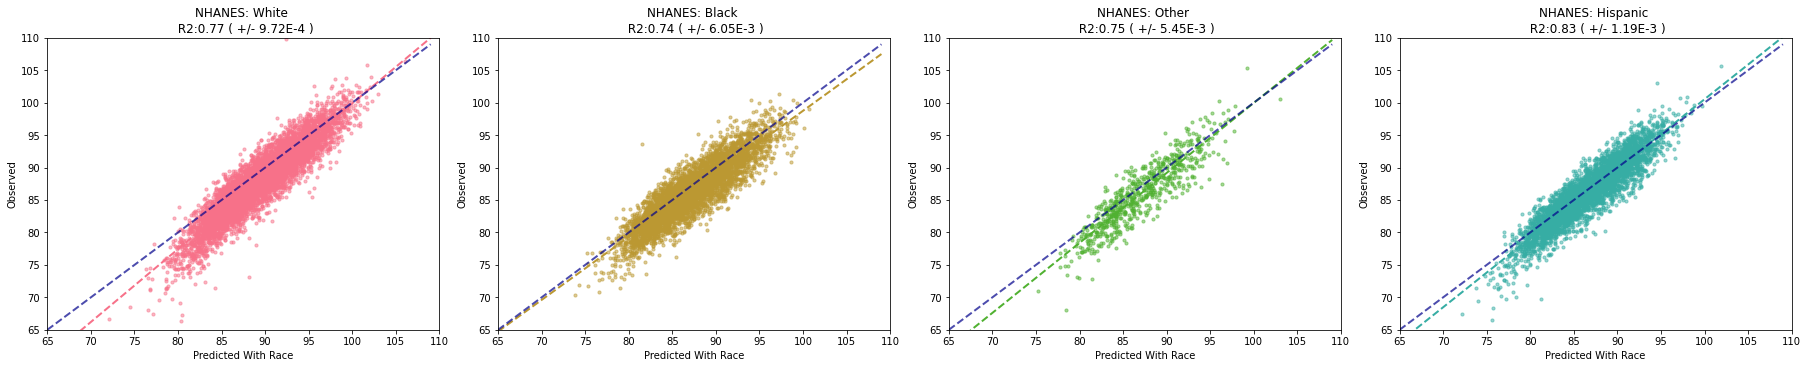

WITHOUT RACE AS COVARIATE:


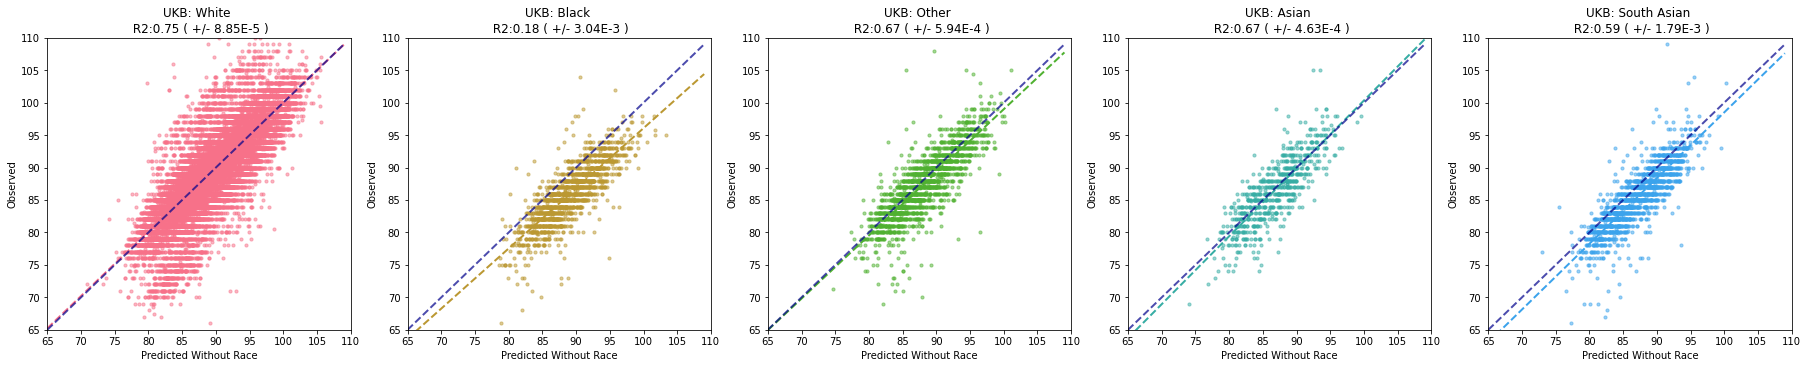

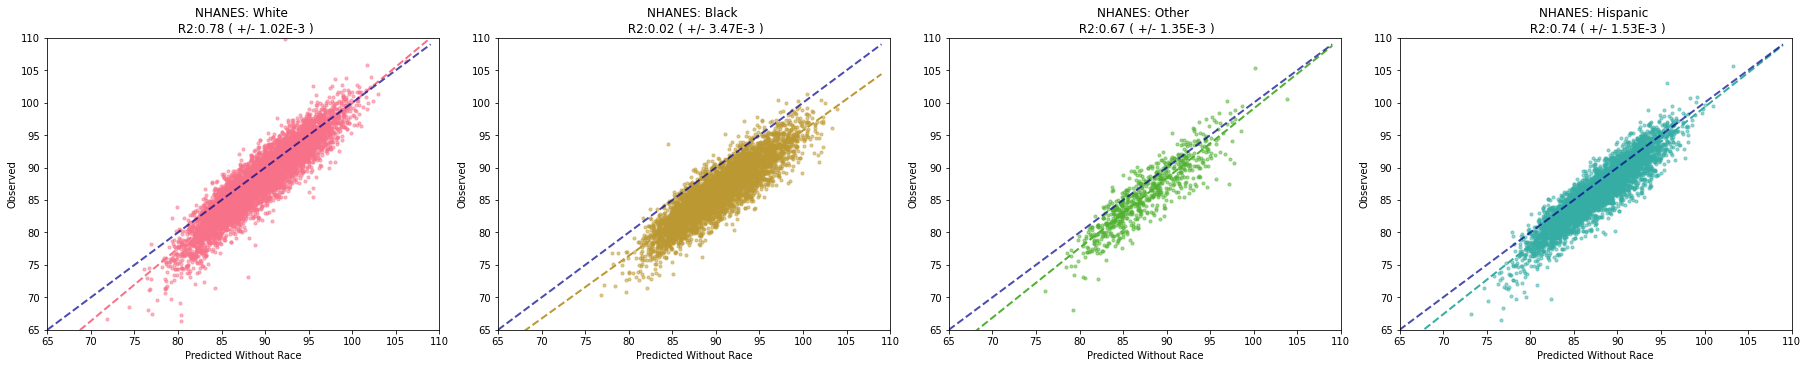

In [21]:
print('WITH RACE AS COVARIATE:')
display(fig1)
display(fig2)

print('WITHOUT RACE AS COVARIATE:')
display(fig3)
display(fig4)